In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import copy
from astropy.stats import biweight_midcorrelation
from scipy.spatial.distance import correlation
from scipy.spatial.distance import pdist, squareform
from minepy import MINE

In [2]:
# open the excel file (Pandas backend utilized)

# $$$
# $$$please note that one should read the 'China Lake.xlsx' in the coursework folder, becasue some of the column names are changed for simplicity.$$$
# $$$

data_chla = pd.read_excel('China Lake.xlsx', sheet_name = 'CHLA')
data_tem = pd.read_excel('China Lake.xlsx', sheet_name = 'TEMPERATURE')
data_p = pd.read_excel('China Lake.xlsx', sheet_name = 'Total P')

In [3]:
# initial data preprocessing

# dictionary structures to store statistical results
dic_depth = {}
dic_station = {}

# calculate statistical results of the data
for i in range(30):
    dic_depth[i] = len(data_chla[data_chla['Depth']==i])+len(data_tem[data_tem['Depth']==i])+len(data_p[data_p['Depth']==i])
    
for i in range(3):
    dic_station[i] = len(data_chla[data_chla['Station']==i])+len(data_tem[data_tem['Station']==i])+len(data_p[data_p['Station']==i])

print(dic_depth)  # From the result, we can see that most data are acquired at depth = 7
print(dic_station) # From the result, we can see that most data are acquired at station = 1

# filter data with condition depth = 7 and station = 1
subData_chla = data_chla[(data_chla['Depth']==7) & (data_chla['Station']==1)]
subData_tem = data_tem[(data_tem['Depth']==7) & (data_tem['Station']==1)]
subData_p = data_p[(data_p['Depth']==7) & (data_p['Station']==1)]

{0: 146, 1: 210, 2: 159, 3: 205, 4: 158, 5: 218, 6: 215, 7: 876, 8: 269, 9: 220, 10: 242, 11: 184, 12: 152, 13: 179, 14: 291, 15: 191, 16: 115, 17: 149, 18: 103, 19: 147, 20: 101, 21: 286, 22: 83, 23: 112, 24: 95, 25: 95, 26: 31, 27: 12, 28: 4, 29: 2}
{0: 0, 1: 5010, 2: 308}


In [4]:
# further processing

# create a data frame for daily data
dayData = pd.DataFrame(columns=['Station','Depth','Date','CHLA','Temperature','Total P'])

# merge three seperated tables into one
for day in subData_chla['Date']:
    chla = subData_chla[subData_chla['Date']==day]['CHLA'].mean() if not subData_chla[subData_chla['Date']==day]['CHLA'].empty else np.nan
    tem = subData_tem[subData_tem['Date']==day]['Temperature'].mean() if not subData_tem[subData_tem['Date']==day]['Temperature'].empty else np.nan
    p = subData_p[subData_p['Date']==day]['Total P'].mean() if not subData_p[subData_p['Date']==day]['Total P'].empty else np.nan
    dayData = dayData.append([{'Station':1, 'Depth':7, 'Date':day, 'CHLA':chla, 'Temperature':tem, 'Total P':p}])

dayData_missing = dayData[dayData.isnull().T.any()] # keep tuples with any missing values 
dayData = dayData.dropna() # drop tuples with any missing values 

# create a data frame for monthly data
monthData = pd.DataFrame(columns=['Station','Depth','Date','CHLA','Temperature','Total P'])

# fill in tuples for monthly data table
for year in range(1998, 2014):
    for month in range(5, 11):
        start = pd.to_datetime(str(year)+'-'+str(month)+'-01')
        end = pd.to_datetime(str(year)+'-'+str(month+1)+'-01')
        # filter candidate data based on month
        subMonthData = dayData[(dayData['Date']>=start) & (dayData['Date']<end)]
        if subMonthData.empty:
            # if no valid candidate data, find back into the kept table of incomplete tuples
            fixer = dayData_missing[(dayData_missing['Date']>=start) & (dayData_missing['Date']<end)]
            if fixer.empty:
                # if still no findings, set the rwo as an empty row but still keep its place
                monthData = monthData.append([{'Station':1, 'Depth':7, 'Date':start, 'CHLA':np.nan, 'Temperature':np.nan, 'Total P':np.nan}], ignore_index=True)
            else:
                # if valid candidates are found, fix some values
                tuple = dict(fixer.mean().T)
                tuple['Date'] =start
                monthData = monthData.append([tuple], ignore_index=True)
        else:
            # if there are already valid complete tuples, use the average of these tuples 
            tuple = dict(subMonthData.mean().T)
            tuple['Date'] = start
            monthData = monthData.append([tuple], ignore_index=True)

data = monthData
print(data)

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:34: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
E:\Anaconda\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.


    Station  Depth       Date      CHLA  Temperature  Total P
0       1.0    7.0 1998-05-01  0.003785        13.30      NaN
1       1.0    7.0 1998-06-01  0.004890        17.70  0.01350
2       1.0    7.0 1998-07-01  0.006355        19.40  0.01300
3       1.0    7.0 1998-08-01  0.015310        21.50  0.01700
4       1.0    7.0 1998-09-01  0.025100        20.80  0.01925
..      ...    ...        ...       ...          ...      ...
91      1.0    7.0 2013-06-01  0.018000        16.95  0.01900
92      1.0    7.0 2013-07-01       NaN          NaN      NaN
93      1.0    7.0 2013-08-01  0.019000        19.85  0.01875
94      1.0    7.0 2013-09-01  0.022000        18.50  0.02000
95      1.0    7.0 2013-10-01  0.005800        16.70  0.01800

[96 rows x 6 columns]


In [5]:
# Task 1
# Method 1: filling with mean values

data_mean = copy.deepcopy(data) #copy data

# helper functions helps to fix missing values with averages following: (month1+month2)/2=month3
def helper(a,b):
    if (pd.isnull(data_mean.iloc[a,b])):
        reference = a % 6 # take a year (May - November) as a segment
        # determine month's position of the year and how to fix it
        if (reference == 0):
            if ((not pd.isnull(data_mean.iloc[a+1,b])) and (not pd.isnull(data_mean.iloc[a+2,b]))):
                data_mean.iloc[a,b] = 2 * data_mean.iloc[a+2,b] - data_mean.iloc[a+1,b]
        elif (reference == 1):
            if ((not pd.isnull(data_mean.iloc[a-1,b])) and (not pd.isnull(data_mean.iloc[a+1,b]))):
                data_mean.iloc[a,b] = 2 * data_mean.iloc[a+1,b] - data_mean.iloc[a-1,b]
            elif ((not pd.isnull(data_mean.iloc[a+1,b])) and (not pd.isnull(data_mean.iloc[a+2,b]))):
                data_mean.iloc[a,b] = 2 * data_mean.iloc[a+2,b] - data_mean.iloc[a+1,b]
        else:
            if ((not pd.isnull(data_mean.iloc[a-1,b])) and (not pd.isnull(data_mean.iloc[a-2,b]))):
                data_mean.iloc[a,b] = (data_mean.iloc[a-1,b] + data_mean.iloc[a-2,b]) / 2

for i in range(data_mean.shape[1]):
    for j in range(data_mean.shape[0]):
        helper(j,i)
# double check for all fixable missing values are fixed
for i in range(data_mean.shape[1]):
    for j in range(data_mean.shape[0]):
        helper(j,i)
data_mean.dropna(inplace=True)

print(data_mean)
data_mean.to_excel('mean_value.xlsx')
print("=============== Completed =================")

    Station  Depth       Date      CHLA  Temperature  Total P
0       1.0    7.0 1998-05-01  0.003785       13.300  0.01250
1       1.0    7.0 1998-06-01  0.004890       17.700  0.01350
2       1.0    7.0 1998-07-01  0.006355       19.400  0.01300
3       1.0    7.0 1998-08-01  0.015310       21.500  0.01700
4       1.0    7.0 1998-09-01  0.025100       20.800  0.01925
..      ...    ...        ...       ...          ...      ...
91      1.0    7.0 2013-06-01  0.018000       16.950  0.01900
92      1.0    7.0 2013-07-01  0.013900       14.225  0.01875
93      1.0    7.0 2013-08-01  0.019000       19.850  0.01875
94      1.0    7.0 2013-09-01  0.022000       18.500  0.02000
95      1.0    7.0 2013-10-01  0.005800       16.700  0.01800

[86 rows x 6 columns]
=============== Completed =================


In [6]:
# Task 1
# Method 2: Linear interpolation

data_inter = copy.deepcopy(data) # copy data

# apply linear interpolation to each column of the data
for frame in data_inter:
    # bidirectional interpolation (containing extrapolation)
    data_inter[frame].interpolate(method='pchip',limit_direction='both',limit_area=None,inplace=True)

print(data_inter)
data_inter.to_excel('interpolation.xlsx')
print("=============== Completed =================")

    Station  Depth       Date      CHLA  Temperature   Total P
0       1.0    7.0 1998-05-01  0.003785     13.30000  0.017000
1       1.0    7.0 1998-06-01  0.004890     17.70000  0.013500
2       1.0    7.0 1998-07-01  0.006355     19.40000  0.013000
3       1.0    7.0 1998-08-01  0.015310     21.50000  0.017000
4       1.0    7.0 1998-09-01  0.025100     20.80000  0.019250
..      ...    ...        ...       ...          ...       ...
91      1.0    7.0 2013-06-01  0.018000     16.95000  0.019000
92      1.0    7.0 2013-07-01  0.018529     19.01207  0.018875
93      1.0    7.0 2013-08-01  0.019000     19.85000  0.018750
94      1.0    7.0 2013-09-01  0.022000     18.50000  0.020000
95      1.0    7.0 2013-10-01  0.005800     16.70000  0.018000

[96 rows x 6 columns]
=============== Completed =================


Mean value method average: 0.015
Mean value method range: 0.106
Mean value method standard deviation: 0.013
Interpolation method average: 0.015
Interpolation method range: 0.05
Interpolation method standard deviation: 0.009


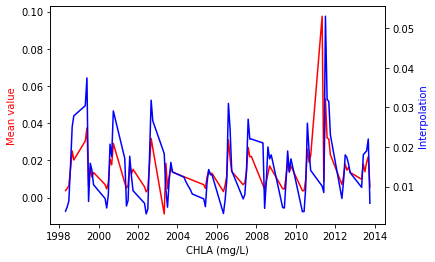

In [7]:
# data visualization (CHLA for both methods)

# draw plot
fig,ax1 = plt.subplots()
ax2 = ax1.twinx()           # mirror
ax1.plot(data_mean['Date'], data_mean['CHLA'], 'r-')
ax2.plot(data_inter['Date'], data_inter['CHLA'], 'b-')
 
ax1.set_xlabel('CHLA (mg/L)')    #x title
ax1.set_ylabel('Mean value',color = 'r')   #y1 title
ax2.set_ylabel('Interpolation',color = 'b')   #y2 title

print('Mean value method average:', round(data_mean['CHLA'].mean(), 3))
print('Mean value method range:', round(data_mean['CHLA'].max()-data_mean['CHLA'].min(), 3))
print('Mean value method standard deviation:', round(data_mean['CHLA'].std(), 3))
print('Interpolation method average:', round(data_inter['CHLA'].mean(), 3))
print('Interpolation method range:', round(data_inter['CHLA'].max()-data_inter['CHLA'].min(), 3))
print('Interpolation method standard deviation:', round(data_inter['CHLA'].std(), 3))

Mean value method average: 17.918
Mean value method range: 21.05
Mean value method standard deviation: 3.496
Interpolation method average: 17.002
Interpolation method range: 14.0
Interpolation method standard deviation: 3.301


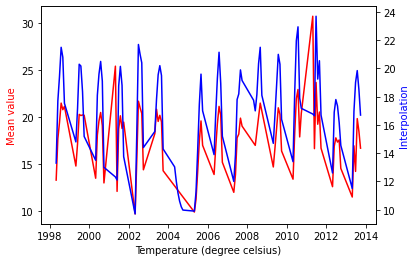

In [8]:
# data visualization (Temperature for both methods)

# draw plot
fig,ax1 = plt.subplots()
ax2 = ax1.twinx()           # mirror
ax1.plot(data_mean['Date'], data_mean['Temperature'], 'r-')
ax2.plot(data_inter['Date'], data_inter['Temperature'], 'b-')
 
ax1.set_xlabel('Temperature (degree celsius)')    #x title
ax1.set_ylabel('Mean value',color = 'r')   #y1 title
ax2.set_ylabel('Interpolation',color = 'b')   #y2 title

print('Mean value method average:', round(data_mean['Temperature'].mean(), 3))
print('Mean value method range:', round(data_mean['Temperature'].max()-data_mean['Temperature'].min(), 3))
print('Mean value method standard deviation:', round(data_mean['Temperature'].std(), 3))
print('Interpolation method average:', round(data_inter['Temperature'].mean(), 3))
print('Interpolation method range:', round(data_inter['Temperature'].max()-data_inter['Temperature'].min(), 3))
print('Interpolation method standard deviation:', round(data_inter['Temperature'].std(), 3))

Mean value method average: 0.017
Mean value method range: 0.015
Mean value method standard deviation: 0.003
Interpolation method average: 0.018
Interpolation method range: 0.014
Interpolation method standard deviation: 0.003


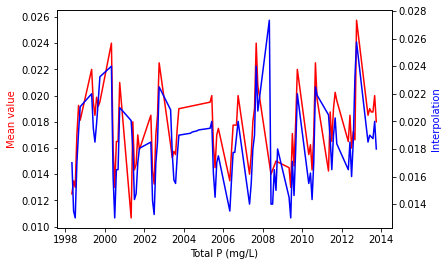

In [9]:
# data visualization (Total P for both methods)

# draw plot
fig,ax1 = plt.subplots()
ax2 = ax1.twinx()           # mirror
ax1.plot(data_mean['Date'], data_mean['Total P'], 'r-')
ax2.plot(data_inter['Date'], data_inter['Total P'], 'b-')
 
ax1.set_xlabel('Total P (mg/L)')    # x title
ax1.set_ylabel('Mean value',color = 'r')   # y1 title
ax2.set_ylabel('Interpolation',color = 'b')   # y2 title

print('Mean value method average:', round(data_mean['Total P'].mean(), 3))
print('Mean value method range:', round(data_mean['Total P'].max()-data_mean['Total P'].min(), 3))
print('Mean value method standard deviation:', round(data_mean['Total P'].std(), 3))
print('Interpolation method average:', round(data_inter['Total P'].mean(), 3))
print('Interpolation method range:', round(data_inter['Total P'].max()-data_inter['Total P'].min(), 3))
print('Interpolation method standard deviation:', round(data_inter['Total P'].std(), 3))

In [10]:
# Task 2: Feature correlation evaluation

data_analyze = data_mean[['CHLA','Temperature','Total P']]

#correlation matrices
pcf_mtx = data_analyze.corr(method='pearson') # 1.Pearson correlation matrix
scf_mtx = data_analyze.corr(method='spearman') # 2.Spearman correlation matrix
kcf_mtx = data_analyze.corr(method='kendall') # 3.Kendall correlation matrix

bicorr1 = biweight_midcorrelation(data_analyze['CHLA'], data_analyze['CHLA'])
bicorr2 = biweight_midcorrelation(data_analyze['CHLA'], data_analyze['Temperature'])
bicorr3 = biweight_midcorrelation(data_analyze['CHLA'], data_analyze['Total P'])
bicorr =  {'CHLA':bicorr1, 'Temperature':bicorr2, 'Total P':bicorr3}
bmf_mtx = pd.DataFrame(bicorr, index = ['CHLA']) # 4.Biweighted midcorrelation matrix

mine = MINE()
mine.compute_score(data_analyze['CHLA'],data_analyze['CHLA'])
mic1 = mine.mic()
mine.compute_score(data_analyze['CHLA'],data_analyze['Temperature'])
mic2 = mine.mic()
mine.compute_score(data_analyze['CHLA'],data_analyze['Total P'])
mic3 = mine.mic()
mic = {'CHLA':mic1, 'Temperature':mic2, 'Total P':mic3}
mic_mtx = pd.DataFrame(mic, index = ['CHLA']) # 5.Maximal information coefficient

# show results (matrices)
print('\nPearson correlation matrix:\n', pcf_mtx)
print('\nSpearman correlation matrix:\n', scf_mtx)
print('\nKendall correlation matrix:\n', kcf_mtx)
print('\nBiweighted midcorrelation matrix:\n', bmf_mtx)
print('\nMaximal information coefficient matrix:\n', mic_mtx)


Pearson correlation matrix:
                  CHLA  Temperature   Total P
CHLA         1.000000     0.516167  0.217029
Temperature  0.516167     1.000000 -0.242729
Total P      0.217029    -0.242729  1.000000

Spearman correlation matrix:
                  CHLA  Temperature   Total P
CHLA         1.000000     0.419223  0.491585
Temperature  0.419223     1.000000 -0.173602
Total P      0.491585    -0.173602  1.000000

Kendall correlation matrix:
                  CHLA  Temperature   Total P
CHLA         1.000000     0.293359  0.333799
Temperature  0.293359     1.000000 -0.122243
Total P      0.333799    -0.122243  1.000000

Biweighted midcorrelation matrix:
       CHLA  Temperature   Total P
CHLA   1.0     0.347632  0.504578

Maximal information coefficient matrix:
       CHLA  Temperature   Total P
CHLA   1.0     0.349548  0.477061


In [11]:
#show factor rankings:

print('\nPearson correlation ranking:\n', pcf_mtx.iloc[0,:].rank(ascending=False))
print('\nKendall correlation ranking:\n', kcf_mtx.iloc[0,:].rank(ascending=False))
print('\nSpearman correlation ranking:\n', scf_mtx.iloc[0,:].rank(ascending=False))
print('\nBiweighted midcorrelation ranking:\n', bmf_mtx.iloc[0,:].rank(ascending=False))
print('\nMaximal information coefficient ranking:\n', mic_mtx.iloc[0,:].rank(ascending=False))


Pearson correlation ranking:
 CHLA           1.0
Temperature    2.0
Total P        3.0
Name: CHLA, dtype: float64

Kendall correlation ranking:
 CHLA           1.0
Temperature    3.0
Total P        2.0
Name: CHLA, dtype: float64

Spearman correlation ranking:
 CHLA           1.0
Temperature    3.0
Total P        2.0
Name: CHLA, dtype: float64

Biweighted midcorrelation ranking:
 CHLA           1.0
Temperature    3.0
Total P        2.0
Name: CHLA, dtype: float64

Maximal information coefficient ranking:
 CHLA           1.0
Temperature    3.0
Total P        2.0
Name: CHLA, dtype: float64
